In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 21 15:52:58 2017

@author: meenakshi
"""

import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing/"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()
    
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

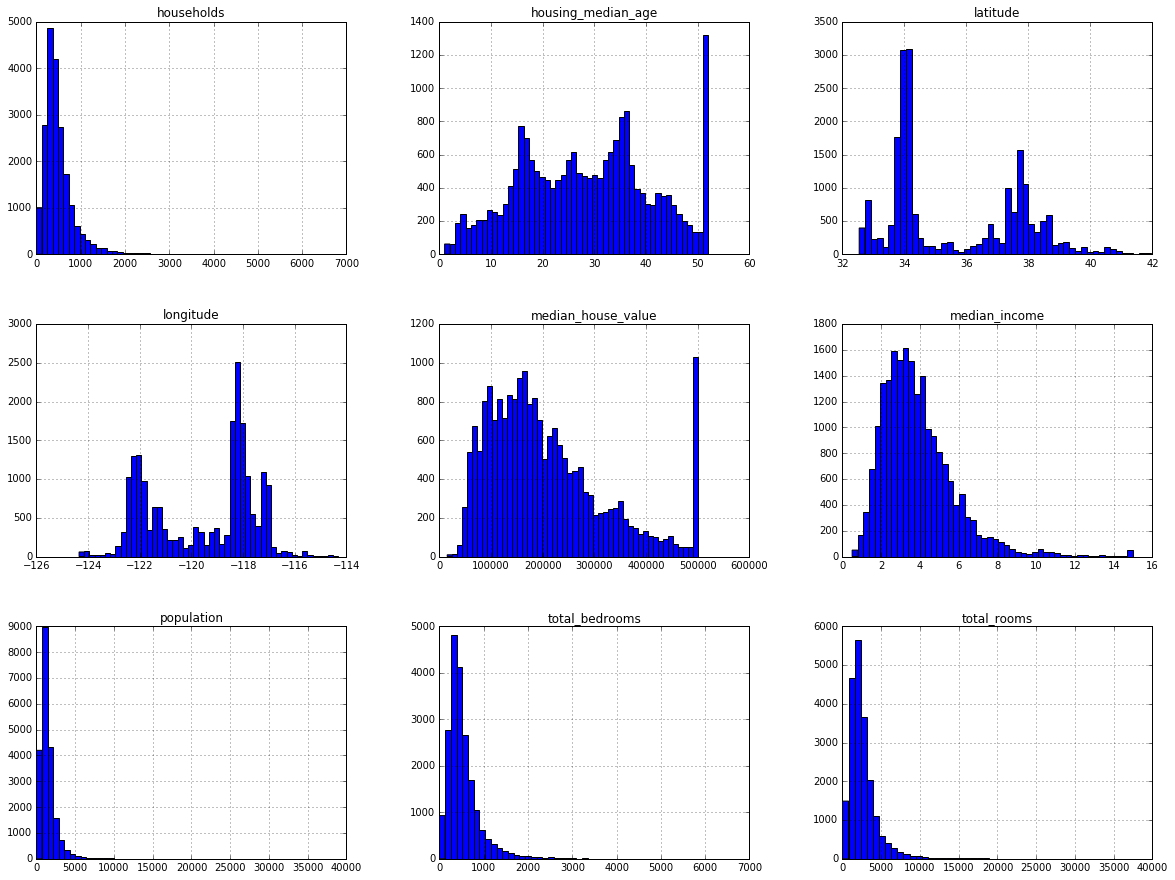

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 21 16:14:51 2017

@author: meenakshi
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split

HOUSING_PATH = "datasets/housing/"

housing = pd.read_csv(HOUSING_PATH + "housing.csv")
housing.hist(bins = 50, figsize = (20,15))
plt.show()

def split_train_test(data, test_ratio):
    #np.random.seed(42) to fix the permutation for different runs
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data)*test_ratio)
    test_ind = shuffled_indices[:test_size]
    train_ind = shuffled_indices[test_size:]
    return data.iloc[test_ind], data.iloc[train_ind]
    
test_set, train_set = split_train_test(housing, 0.2)

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256*test_ratio
    
def test_train_split_hash(data, test_ratio, id_col, hash = hashlib.md5):
    ids = data[id_col]
    test_set_id = ids.apply(lambda idval:test_set_check(idval, test_ratio, hash))
    return data.loc[test_set_id], data.loc[~test_set_id]
    
housing.reset_index(inplace = True)

test_set, train_set = test_train_split_hash(housing, 0.2, "index")





In [5]:
housing['median_income_binned'] = np.ceil(housing['median_income']/1.5)
housing.columns

Index(['index', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'median_income_binned'],
      dtype='object')

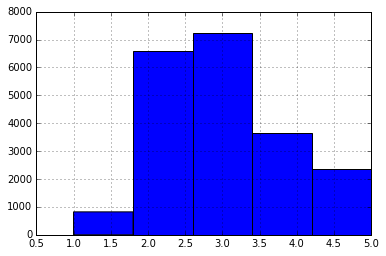

In [6]:
housing['median_income_binned'].where(housing['median_income_binned'] < 5, 5.0, inplace = True)
housing['median_income_binned'].hist(bins = 5)
plt.show()

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

In [8]:
for train_idx, test_idx in split.split(housing, housing['median_income_binned']):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]

In [9]:
housing["median_income_binned"].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: median_income_binned, dtype: float64

In [10]:
strat_test_set["median_income_binned"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: median_income_binned, dtype: float64

In [11]:
strat_train_set.drop("median_income_binned", axis = 1, inplace = True)
strat_test_set.drop("median_income_binned", axis = 1, inplace = True)

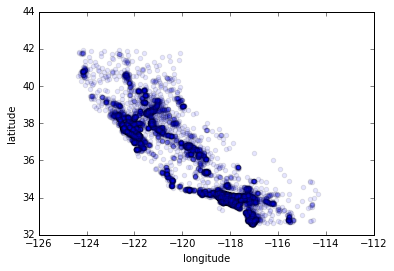

In [12]:
housing = strat_train_set.copy()
housing.plot(kind = "scatter", x = 'longitude', y = 'latitude', alpha = 0.1)
plt.show()

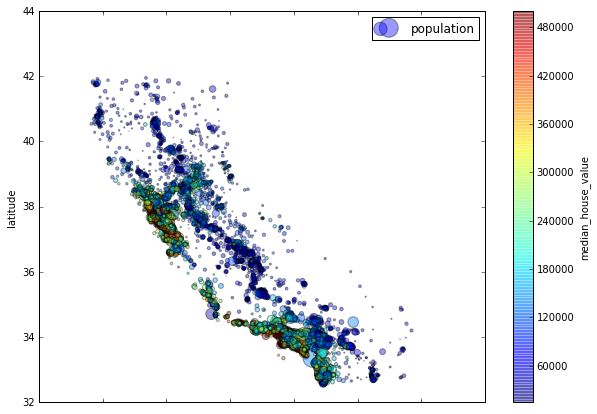

In [13]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4, s = housing['population']/100, label = 'population', figsize = (10, 7), c = 'median_house_value', cmap = plt.get_cmap('jet'), colorbar = True)
plt.show()

In [14]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
index                 0.067723
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

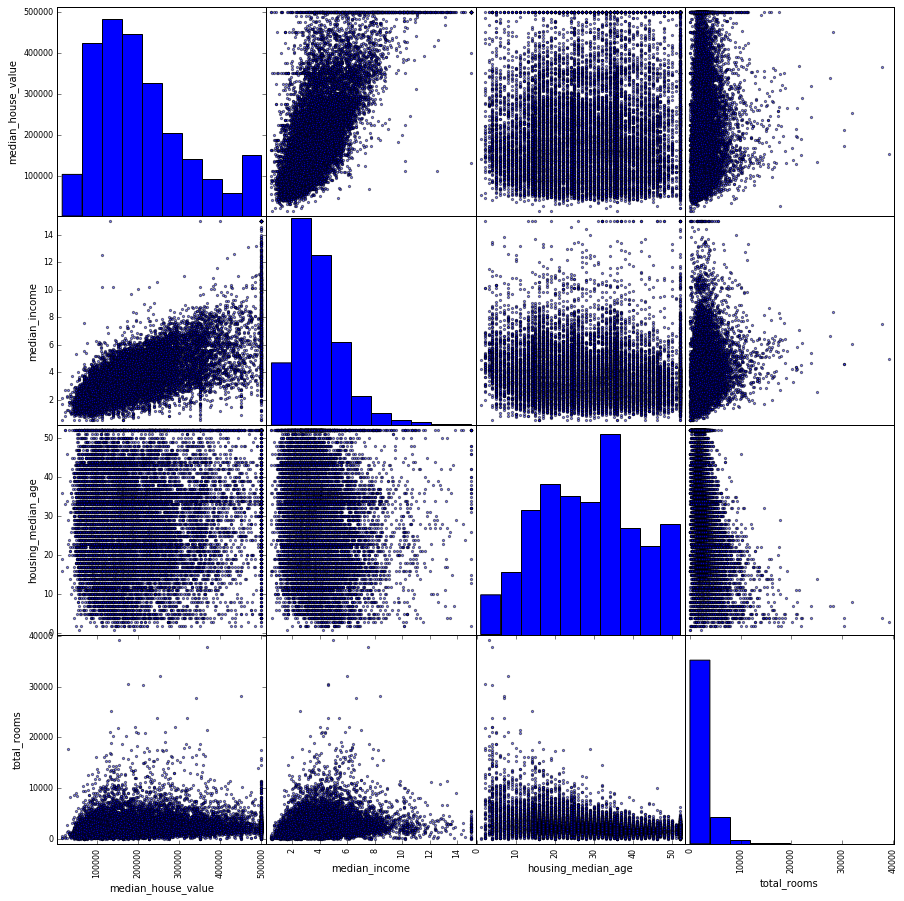

In [18]:
from pandas.tools.plotting import scatter_matrix

to_plot = ['median_house_value', 'median_income', 'housing_median_age', 'total_rooms']
scatter_matrix(housing[to_plot], figsize = (15,15))
plt.show()

In [30]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy = "median", axis = 1)
ocean_proximity = housing['ocean_proximity']
housing.drop('ocean_proximity', axis = 1, inplace = True)
imputer.fit(housing)

X = imputer.transform(housing)
housing = pd.DataFrame(X, columns = housing.columns)
housing['ocean_proximity'] = ocean_proximity

In [32]:
housing

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,17606,-121.89,37.29,38,1568,351,710,339,2.7042,286600,NEAR BAY
1,18632,-121.93,37.05,14,679,108,306,113,6.4214,340600,NEAR BAY
2,14650,-117.20,32.77,31,1952,471,936,462,2.8621,196900,NEAR BAY
3,3230,-119.61,36.31,25,1847,371,1460,353,1.8839,46300,NEAR BAY
4,3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,254500,NEAR BAY
5,19480,-120.97,37.66,24,2930,588,1448,570,3.5395,127900,NEAR BAY
6,8879,-118.50,34.04,52,2233,317,769,277,8.3839,500001,NEAR BAY
7,13685,-117.24,34.15,26,2041,293,936,375,6.0000,140200,NEAR BAY
8,4937,-118.26,33.99,47,1865,465,1916,438,1.8242,95000,NEAR BAY
9,4861,-118.28,34.02,29,515,229,2690,217,0.4999,500001,NEAR BAY
